In [26]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from urllib.parse import urlparse
import psycopg2, os
from sklearn import preprocessing
from sqlalchemy import create_engine
%matplotlib inline 
import matplotlib.pyplot as plt

In [27]:
postgresURL=urlparse(os.getenv('POSTGRES_URL'))
print(postgresURL)
connection = psycopg2.connect(host=postgresURL.hostname,
                        port=postgresURL.port,
                        user=postgresURL.username,
                        password=postgresURL.password,
                        sslmode='verify-full',
                        sslrootcert='/home/jovyan/cert.pem',
                        database='ibmclouddb')

ParseResult(scheme='postgres', netloc='ibm_cloud_33e066c0_e55c_44a9_82eb_e4e2fbba067e:dca85a571fb4251d03f92ae4a30edea05dd36e9b5fb77303f51d9b06eb6f6b1b@dc2537b1-f539-4308-aec9-73a918fe9827.bkvfu0nd0m8k95k94ujg.databases.appdomain.cloud:32347', path='/ibmclouddb', params='', query='sslmode=disable', fragment='')


In [31]:
# Importing dataset - the generated simulator data
data = pd.read_sql_query('''SELECT measurement_time, temperature, target_temperature, ambiant_temperature, kilowatts, content_type, oxygen_level,nitrogen_level, carbon_dioxide_level, humidity_level, vent_1, vent_2, vent_3, time_door_open, defrost_cycle, maintenance_required  FROM reefer_telemetries;''',connection)
data.head()

,measurement_time,temperature,target_temperature,ambiant_temperature,kilowatts,content_type,oxygen_level,nitrogen_level,carbon_dioxide_level,humidity_level,vent_1,vent_2,vent_3,time_door_open,defrost_cycle,maintenance_required
0,2019-09-16 23:41:28.424611,4.00000,4.0,18.0000,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,NaN,NaN
1,2019-09-24 23:09:43.684149,6.68969,6.0,22.4282,2.927570,2.0,21.4124,-0.378142,4.03737,0.577301,True,True,True,1.619410,4.0,0.0
2,2019-09-24 23:14:43.684149,5.64922,6.0,18.5116,0.501211,2.0,19.6814,2.460760,4.24245,1.201170,True,True,True,0.170088,6.0,0.0
3,2019-09-24 23:19:43.684149,4.91638,6.0,20.8881,2.636550,2.0,20.7648,1.601000,2.75441,2.501910,True,True,True,2.273720,6.0,0.0
4,2019-09-24 23:24:43.684149,4.23752,6.0,20.1854,3.071450,2.0,21.1276,0.601678,2.54371,-0.589239,True,True,True,1.029000,3.0,0.0


In [32]:
# Clean bad data
data=data.dropna()
data.head()

,measurement_time,temperature,target_temperature,ambiant_temperature,kilowatts,content_type,oxygen_level,nitrogen_level,carbon_dioxide_level,humidity_level,vent_1,vent_2,vent_3,time_door_open,defrost_cycle,maintenance_required
1,2019-09-24 23:09:43.684149,6.68969,6.0,22.4282,2.927570,2.0,21.4124,-0.378142,4.03737,0.577301,True,True,True,1.619410,4.0,0.0
2,2019-09-24 23:14:43.684149,5.64922,6.0,18.5116,0.501211,2.0,19.6814,2.460760,4.24245,1.201170,True,True,True,0.170088,6.0,0.0
3,2019-09-24 23:19:43.684149,4.91638,6.0,20.8881,2.636550,2.0,20.7648,1.601000,2.75441,2.501910,True,True,True,2.273720,6.0,0.0
4,2019-09-24 23:24:43.684149,4.23752,6.0,20.1854,3.071450,2.0,21.1276,0.601678,2.54371,-0.589239,True,True,True,1.029000,3.0,0.0
5,2019-09-24 23:29:43.684149,6.47034,6.0,19.6761,0.878999,2.0,20.4821,0.052486,3.29618,1.073720,True,True,True,1.446830,5.0,0.0


In [33]:
# Convert dataset into array for the independent variables (features)
X = np.asarray(data[['temperature','target_temperature','ambiant_temperature','oxygen_level','carbon_dioxide_level','humidity_level','nitrogen_level','vent_1','vent_2','vent_3','kilowatts','content_type','time_door_open','defrost_cycle']])
X[0:5]

array([[6.68969, 6.0, 22.4282, 21.4124, 4.03737, 0.577301, -0.378142,
        True, True, True, 2.92757, 2.0, 1.61941, 4.0],
       [5.64922, 6.0, 18.5116, 19.6814, 4.24245, 1.20117, 2.46076, True,
        True, True, 0.501211, 2.0, 0.170088, 6.0],
       [4.91638, 6.0, 20.8881, 20.7648, 2.75441, 2.50191, 1.601, True,
        True, True, 2.63655, 2.0, 2.27372, 6.0],
       [4.23752, 6.0, 20.1854, 21.1276, 2.54371, -0.589239, 0.601678,
        True, True, True, 3.07145, 2.0, 1.029, 3.0],
       [6.47034, 6.0, 19.6761, 20.4821, 3.29618, 1.07372, 0.0524862,
        True, True, True, 0.878999, 2.0, 1.44683, 5.0]], dtype=object)

In [34]:
# Convert dataset into array for the dependent (objective) variables
y = np.asarray(data['maintenance_required'])
y [0:5]

array([0., 0., 0., 0., 0.])

In [35]:
# Normalize/standardize (mean = 0 and standard deviation = 1) 
# your features before applying machine learning techniques.
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.72426857,  0.        ,  2.33009052,  0.39311177, -0.24251733,
        -0.20171051, -1.20024664,  0.        ,  0.        ,  0.        ,
         0.16770004,  0.        ,  0.59734974, -0.47912416],
       [-0.28030921,  0.        , -1.44867407, -1.39500505, -0.1562471 ,
         0.39906018,  1.64054233,  0.        ,  0.        ,  0.        ,
        -2.28048971,  0.        , -0.89903891,  1.32889153],
       [-0.98786904,  0.        ,  0.84419067, -0.27585672, -0.78221523,
         1.65164121,  0.78021086,  0.        ,  0.        ,  0.        ,
        -0.12593836,  0.        ,  1.27290842,  1.32889153],
       [-1.64331098,  0.        ,  0.16622052,  0.09891439, -0.8708496 ,
        -1.32506019, -0.21977537,  0.        ,  0.        ,  0.        ,
         0.31287458,  0.        , -0.01223379, -1.383132  ],
       [ 0.5124853 ,  0.        , -0.32515588, -0.56788481, -0.55431091,
         0.27632893, -0.76933221,  0.        ,  0.        ,  0.        ,
        -1.89930263,  0.  

In [36]:
## split the dataset into train and test to estiamte model accuracy 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (880, 14) (880,)
Test set: (220, 14) (220,)


In [37]:
## As we are trying to acheive a binary classification, we use Logistic Regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [38]:
## Predict using the trained LR model
yhat = LR.predict(X_test)
yhat

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [39]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[0.82717245, 0.17282755],
       [0.79748133, 0.20251867],
       [0.82892327, 0.17107673],
       [0.85563583, 0.14436417],
       [0.86232989, 0.13767011],
       [0.81686918, 0.18313082],
       [0.84922812, 0.15077188],
       [0.78953743, 0.21046257],
       [0.81464237, 0.18535763],
       [0.85173387, 0.14826613],
       [0.85550875, 0.14449125],
       [0.83189748, 0.16810252],
       [0.8231106 , 0.1768894 ],
       [0.83159007, 0.16840993],
       [0.81962405, 0.18037595],
       [0.85692729, 0.14307271],
       [0.80937676, 0.19062324],
       [0.79987605, 0.20012395],
       [0.79742532, 0.20257468],
       [0.77945867, 0.22054133],
       [0.85219355, 0.14780645],
       [0.80049254, 0.19950746],
       [0.84438717, 0.15561283],
       [0.82324988, 0.17675012],
       [0.8389465 , 0.1610535 ],
       [0.80093853, 0.19906147],
       [0.84069632, 0.15930368],
       [0.85555041, 0.14444959],
       [0.82839349, 0.17160651],
       [0.75228244, 0.24771756],
       [0.

In [40]:
from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat)

1.0

In [41]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    print(confusion_matrix(y_test, yhat, labels=[1,0]))

Confusion matrix, without normalization
[[  5   0]
 [  0 215]]
[[  5   0]
 [  0 215]]


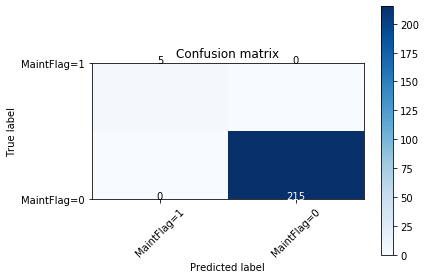

In [42]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['MaintFlag=1','MaintFlag=0'],normalize= False,  title='Confusion matrix')

In [43]:
print (classification_report(y_test, yhat))


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       215
         1.0       1.00      1.00      1.00         5

    accuracy                           1.00       220
   macro avg       1.00      1.00      1.00       220
weighted avg       1.00      1.00      1.00       220



In [44]:

from sklearn.metrics import log_loss
log_loss(y_test, yhat_prob)


0.21668859064200888

In [45]:
import pickle

#serializing our model to a file called model_logistic_regression.pkl
pickle.dump(LR, open("model_logistic_regression.pkl","wb"))